# Clients Side Training

In [31]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn

In [32]:
dataset = pd.read_csv("C:\\Users\\intel\\Desktop\\Arjun Workspace\\B.Tech-Project---Federated-Learning\\Project_file\\Dataset\\feature_selected_voice_data.csv")

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
idx = int(len(dataset)*0.8)
train_df = dataset[:idx]
test_df = dataset[idx:]

In [34]:
idx = int(len(train_df)*0.5)
client1_dataset = train_df[:idx]
client2_dataset = train_df[idx:]

In [35]:
# Client1 dataset -->
client1_X = client1_dataset.iloc[:,:-1]
client1_Y = client1_dataset["label"]
le = preprocessing.LabelEncoder()
client1_Y = le.fit_transform(client1_Y)
client1_X = client1_X.to_numpy()
# client1_Y = client1_Y.to_numpy()

X_train_1 = client1_X.astype('float32')
y_train_1 = client1_Y.astype('float32')

X_train_1 = torch.from_numpy(X_train_1)
y_train_1 =torch.from_numpy(y_train_1)

# Client2 Datatset -->
client2_X = client2_dataset.iloc[:,:-1]
client2_Y = client2_dataset["label"]
le = preprocessing.LabelEncoder()
client2_Y = le.fit_transform(client2_Y)
client2_X = client2_X.to_numpy()
# client2_Y = client2_Y.to_numpy()

X_train_2 = client2_X.astype('float32')
y_train_2 = client2_Y.astype('float32')

X_train_2 = torch.from_numpy(X_train_2)
y_train_2 =torch.from_numpy(y_train_2)

In [36]:
n_samples, n_features = X_train_1.shape

In [37]:
class LogisticRegression(nn.Module):
    def __init__(self, n_input_features):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)
    
    #sigmoid transformation of the input 
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

In [38]:
def clients_training(X_train, y_train, lr):
  num_epochs = 100
  learning_rate = 0.0001 
  criterion = nn.BCELoss() # Binary cross Entropy loss                              
  optimizer = torch.optim.SGD(lr.parameters(), lr=learning_rate) 
  error_loss = []
  accuracy_list = []
  for epoch in range(num_epochs):
      train_loss = 0
      correct = 0
      total = 0
      optimizer.zero_grad()
      y_pred = lr(X_train)
      loss = criterion(y_pred.reshape(1267), y_train)             
      loss.backward()
      optimizer.step()
      # if (epoch+1) % 20 == 0:                                          
      #     print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')
      train_loss += loss.item()*X_train.size(0)
      train_loss = train_loss/1584
      error_loss.append(train_loss)
      total += y_train.size(0)
      predicted = torch.round(torch.relu(y_pred))
      correct += (predicted == y_train).sum().item()
      accuracy = correct/total
      accuracy_list.append(accuracy)
  total_loss = sum(error_loss)/len(error_loss)
  avg_accuracy = sum(accuracy_list)/len(accuracy_list)
  return lr, total_loss, avg_accuracy

#print(lr.parameters()) # printing learnable parameters (weights and biases)
#print(lr.state_dict) # pint dictionary of all parameters
# print(total_loss) # printing total loss in training the model

In [39]:
X_test = test_df.iloc[:,:-1]
y_test = test_df["label"]
le = preprocessing.LabelEncoder()
y_test = le.fit_transform(client1_Y)
X_test = X_test.to_numpy()
# client1_Y = client1_Y.to_numpy()

X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

X_test = torch.from_numpy(X_test)
y_test =torch.from_numpy(y_test)

In [40]:
# model1 = LogisticRegression(n_features)
model = LogisticRegression(n_features)
trained_model, loss1, acc1 = clients_training(X_train_1, y_train_1, model)

In [41]:
with torch.no_grad():
    y_pred = trained_model.forward(X_test)
    predicted = torch.round(y_pred)
    correct = (predicted == y_test).sum().item()
    total = y_test.size(0)
    test_acc = correct / total
    print(f'Testing accuracy: {test_acc:.4f}')

Testing accuracy: 0.0000


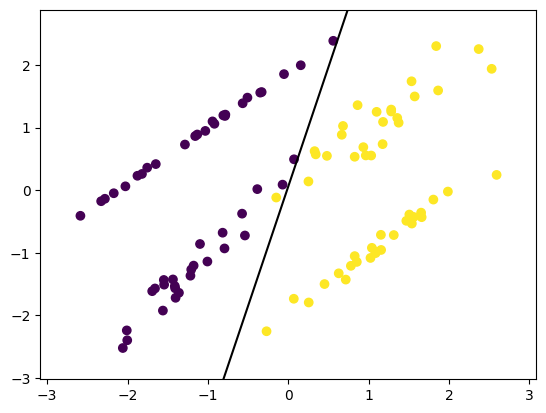

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

# generate a toy binary classification dataset
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, random_state=42)

# train a logistic regression model
model = LogisticRegression()
model.fit(X, y)

# plot the data points and decision boundary
plt.scatter(X[:, 0], X[:, 1], c=y)
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, levels=[0.5], colors='k')
plt.show()


# Server Side Training

In [43]:
import time
import copy
from copy import deepcopy
import matplotlib.pyplot as plt

Train 

In [44]:
def ss_train_r(model, rounds, plt_title="Loss Curve"):
  
  # global model weights
  global_weights = model.state_dict()

  # training loss
  train_loss = []
  train_accuracy = []
  # measure time
  start = time.time()

  for current_round in range(1, rounds+1):

    w, local_loss, acc_ = [], [], []

    # model1 = LogisticRegression(n_features)
    weights1, loss1, acc1 = clients_training(X_train_1, y_train_1, model)

    # model2 = LogisticRegression(n_features)
    weights2, loss2, acc2 = clients_training(X_train_2, y_train_2, model)

    w.append(copy.deepcopy(weights1))
    w.append(copy.deepcopy(weights2))
    # print(loss1)
    # print(loss2)
    local_loss.append(copy.deepcopy(loss1))
    local_loss.append(copy.deepcopy(loss2))
    
    acc_.append(copy.deepcopy(acc1))
    acc_.append(copy.deepcopy(acc2))

    # updating the global weights
    weights_avg = copy.deepcopy(w[0])
    for k in weights_avg.keys():
      for i in range(1, len(w)):
        weights_avg[k] += w[i][k]

      weights_avg[k] = torch.div(weights_avg[k], len(w))
    global_weights = weights_avg

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    print('Round: {}... \tAverage Loss: {}'.format(current_round, round(loss_avg, 3)))
    train_loss.append(loss_avg)
    
    # accuracy
    acc_avg = sum(acc_) / len(acc_)
    train_accuracy.append(acc_avg/2)

  end = time.time()
  
  
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(train_loss)
  ax.plot(x_axis, y_axis, 'tab:'+"orange")
  ax.set(xlabel='Number of Rounds', ylabel='Training Loss', title="Loss Curve for tw0 clients")
  ax.grid()
  fig.savefig('Loss_curve.jpg', format='jpg')

  fig1, ax1 = plt.subplots()
  x_axis1 = np.arange(1, rounds+1)
  y_axis1 = np.array(train_accuracy)
  ax1.plot(x_axis1, y_axis1, 'tab:'+"blue")
  ax1.set(xlabel='Number of Rounds', ylabel='Training Accuracy', title="Accuracy Curve for two clients")
  ax1.grid()
  fig1.savefig('Accuracy_Curve.jpg', format='jpg')
  print("Training Done!")
  print("Total time taken to Train: {}".format(end-start))

  return model, sum(train_accuracy)/ len(train_accuracy), sum(train_loss)/len(train_loss)

In [45]:
model = LogisticRegression(n_features)

if torch.cuda.is_available():
  model.cuda()

server_training, total_training_acc, total_training_loss = ss_train_r(model, 20,"Loss Curve")

AttributeError: 'LogisticRegression' object has no attribute 'state_dict'

In [ ]:
X_test = test_df.iloc[:,:-1]
y_test = test_df["label"]
le = preprocessing.LabelEncoder()
y_test = le.fit_transform(client1_Y)
X_test = X_test.to_numpy()
# client1_Y = client1_Y.to_numpy()

X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

X_test = torch.from_numpy(X_test)
y_test =torch.from_numpy(y_test)

In [ ]:
print("Total Training Loss after {} rounds: {}".format(100, total_training_loss))
print("Total Training Accuracy after {} rounds: {}".format(100, total_training_acc))

In [ ]:
model = LogisticRegression(13)

# calculate testing accuracy
with torch.no_grad():
    y_pred = model.forward(X_test)
    predicted = torch.round(y_pred)
    correct = (predicted == y_test).sum().item()
    total = y_test.size(0)
    test_acc = correct / total
    print(f'Testing accuracy: {test_acc:.4f}')

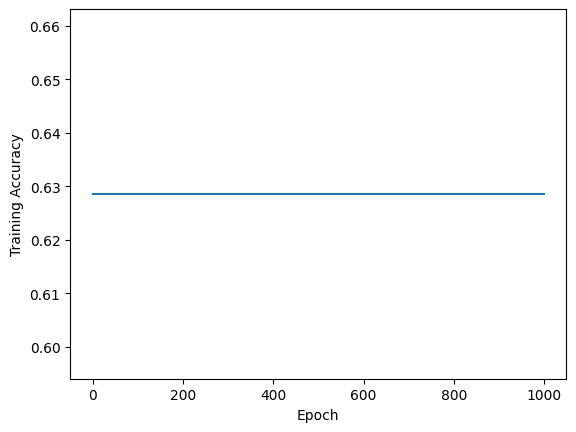

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Load the breast cancer dataset
data = load_breast_cancer()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=42)

# Define the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(30, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Create an instance of the neural network
net = Net()

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

# Train the neural network
num_epochs = 1000
train_losses = []
train_accuracy = []
for epoch in range(num_epochs):
    # Train the model on the training data
    net.train()
    optimizer.zero_grad()
    outputs = net(torch.tensor(X_train).float())
    loss = criterion(outputs.squeeze(), torch.tensor(y_train).float())
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Evaluate the model on the training data
    net.eval()
    with torch.no_grad():
        outputs = net(torch.tensor(X_train).float())
        predicted = np.round(outputs.detach().numpy())
        correct = (predicted == y_train.reshape(-1, 1)).sum().item()
        accuracy = correct / len(y_train)
        train_accuracy.append(accuracy)

for i in range(len(train_accuracy)):  
    plt.plot(range(10), train_accuracy[i], label="Client: {}".format(values[i]))
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.show()


        # # Stop training if training accuracy reaches 50%
        # if accuracy >= 0.5:
        #     print("Training accuracy reached 50% at epoch", epoch+1)
        #     break

# Plot the training accuracy over epochs
plt.plot(train_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.show()


# Training and Testing

In [ ]:
def data_partition(dataset, clients):
  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data = pd.read_csv('C:\\Users\\intel\\Desktop\\Arjun Workspace\\B.Tech-Project---Federated-Learning\\Project_file\\Dataset\\feature_selected_voice_data.csv')

In [ ]:
temp = data_partition(data, 2)

In [ ]:
for key,value in temp.items():
	print(key, ':', value)

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, datasets
from torchsummary import summary

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, dataset, idxs):
      self.dataset = Dataset
      self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, item):
      X_train, y_train = self.dataset[self.idxs[item]]
      return X_train, y_train

In [ ]:
train_loader = DataLoader(CustomDataset(data, temp[1]), batch_size=100, shuffle=True)


In [ ]:
for X_train, y_train in train_loader:
  if torch.cuda.is_available():
    X_train, y_train = X_train.cuda(), y_train.cuda()

In [ ]:
# logistic regression class
class LogisticRegression(nn.Module):
    def __init__(self, n_input_features):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)
    
    #sigmoid transformation of the input 
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

In [ ]:
Model_LR = LogisticRegression()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
def train(model):
  for idxs in range(2):
    train_loader = DataLoader(CustomDataset(data, temp[0]), batch_size=100, shuffle=True)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)
    # optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)

    
    for X_train, y_train in train_loader:
      if torch.cuda.is_available():
        X_train, y_train = X_train.cuda(), y_train.cuda()

        
